In [85]:
import numpy as np
import cv2
import imutils
import operator
import matplotlib.pyplot as plt
img = cv2.imread("test.jpeg",0)
def preprocess_image(img):
    ratio = img.shape[0]/500.0
    orig = img.copy()
    proc = cv2.GaussianBlur(orig.copy(),(9,9),0)
    proc = cv2.adaptiveThreshold(proc,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    proc = cv2.bitwise_not(proc,proc)
    plt.imshow(proc,cmap="gray")
    plt.show()
    return proc


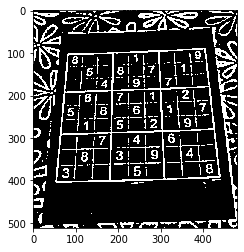

In [86]:
edged = preprocess_image(img)

In [89]:
def find_contours(edged):
    contours = cv2.findContours(edged.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours,key = cv2.contourArea,reverse=True)
    pts1=[]
    for c in contours:
        peri = cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,0.02*peri,True)
        if len(approx) == 4:
            screencnt = approx
            cv2.drawContours(img,[screencnt],-1,(0,255,0),2)
            n= approx.ravel()
            i=0
            for j in n:
                if i%2 == 0:
                    x=n[i]
                    y=n[i+1]
                    pts1.append([x,y])
                i+=1    
            break
    plt.imshow(img,cmap = "gray")
    return screencnt


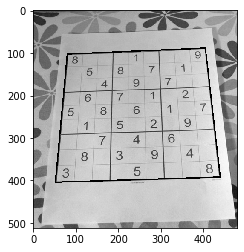

In [90]:
screencnt = find_contours(edged)

In [91]:
def fin_edges(screencnt):
    bottom_right,_ = max(enumerate(pt[0][0] + pt[0][1] for pt in screencnt),key=operator.itemgetter(1))
    top_left,_ = min(enumerate(pt[0][0] + pt[0][1] for pt in screencnt),key=operator.itemgetter(1))
    bottom_left,_= min(enumerate(pt[0][0] - pt[0][1] for pt in screencnt),key=operator.itemgetter(1))
    top_right,_ = max(enumerate(pt[0][0] - pt[0][1] for pt in screencnt),key=operator.itemgetter(1))
    return [screencnt[top_left][0],screencnt[top_right][0],screencnt[bottom_right][0],screencnt[bottom_left][0]]

In [92]:
crop_rect = fin_edges(screencnt)

In [93]:
def distance_between(p1,p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a**2) + (b**2))

In [96]:
def perspective_change(crop_rect,img):
    tl,tr,br,bl = crop_rect[0],crop_rect[1],crop_rect[2],crop_rect[3]
    src = np.array([tl,tr,br,bl],dtype='float32')
    side = max([distance_between(br,tr),
               distance_between(tl,bl),
               distance_between(br,bl),
               distance_between(tl,tr)])
    dst  = np.array([[0,0],[side-1,0],[side-1,side-1],[0,side-1]],dtype='float32')

    m = cv2.getPerspectiveTransform(src,dst)

    warpped = cv2.warpPerspective(img,m,(int(side),int(side)))
    plt.imshow(warpped,cmap="gray")
    return warpped,side

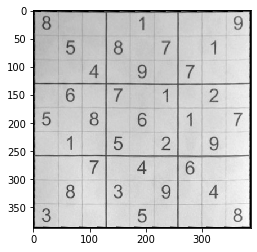

In [97]:
fin_image,side= perspective_change(crop_rect,img)

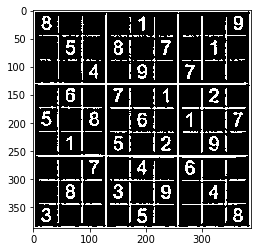

In [99]:
fin_image= preprocess_image(fin_image)

In [100]:
def collect_all_squares(img):
    squares =[]
    side = img.shape[:1]
    side = side[0]/9
    for j in range(9):
        for i in range(9):
            p1 = (i * side,j*side)
            p2 = ((i+1)*side,j+1*side)
            squares.append((p1,p2))
    print("total_number_of squares found is {}".format(len(squares)))        
    return squares

In [101]:
squares = collect_all_squares(fin_image)

total_number_of squares found is 81


In [102]:
def extract_squares(img,square):
    return img[int(square[0][1]) : int(square[1][1]), int(square[0][0]):int(square[1][0])]

In [103]:
extracted_squares = []
for i in squares:
    extracted_squares.append(extract_squares(fin_image,i))

In [104]:
def display_rectangles(img,rects,color=(255,255,255)):
    for rect in rects:
        img =cv2.rectangle(img,tuple(int(x) for x in rect[0]),tuple(int(x)for x in rect[1]),color)
    plt.imshow(img,cmap= "gray")
    return img

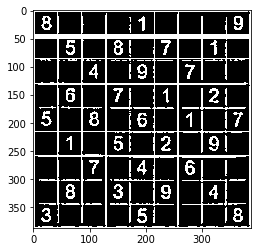

In [105]:
rect_img = display_rectangles(fin_image,squares)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  This is separate from the ipykernel package so we can avoid doing imports until


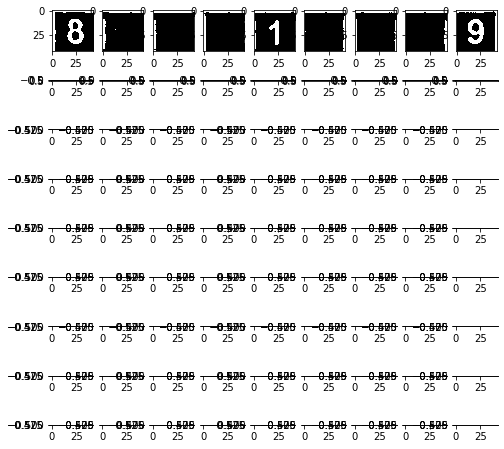

In [112]:
fig, axes = plt.subplots(9,9, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(extracted_squares[i],cmap="gray")